## 부적절하게 큰 학습률
전에 사용했던 MNIST 모델을 부적절하게 큰 학습률인 1.0으로 훈련해보자

In [77]:
import keras
from keras import layers
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
375/375 [==============================] - 8s 19ms/step - loss: 662.1410 - acc: 0.3534 - val_loss: 2.8040 - val_acc: 0.3182
Epoch 2/10
375/375 [==============================] - 5s 13ms/step - loss: 5.6788 - acc: 0.2427 - val_loss: 2.2627 - val_acc: 0.2087
Epoch 3/10
375/375 [==============================] - 5s 14ms/step - loss: 3.7761 - acc: 0.2179 - val_loss: 2.2381 - val_acc: 0.2165
Epoch 4/10
375/375 [==============================] - 5s 12ms/step - loss: 3.3506 - acc: 0.2363 - val_loss: 3.2232 - val_acc: 0.3025
Epoch 5/10
375/375 [==============================] - 5s 13ms/step - loss: 2.9133 - acc: 0.2308 - val_loss: 2.1873 - val_acc: 0.1922
Epoch 6/10
375/375 [==============================] - 6s 17ms/step - loss: 2.4773 - acc: 0.2472 - val_loss: 2.3905 - val_acc: 0.2298
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 2.5260 - acc: 0.2627 - val_loss: 2.2268 - val_acc: 0.2239
Ep

결과를 보면 알 수 있듯, 이 모델은 30~40% 정도의 훈련 정확도와 검증 정확도에 빠르게 도달하지만 이를 넘어서지 못하고 있다. 이때 조금 더 합리적인 값인 0001로 학습률을 낮춰보면

In [78]:
import keras
from keras import layers
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 5s 13ms/step - loss: 0.2838 - acc: 0.9187 - val_loss: 0.1453 - val_acc: 0.9584
Epoch 2/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1187 - acc: 0.9643 - val_loss: 0.1046 - val_acc: 0.9693
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0766 - acc: 0.9769 - val_loss: 0.0981 - val_acc: 0.9721
Epoch 4/10
375/375 [==============================] - 5s 13ms/step - loss: 0.0557 - acc: 0.9831 - val_loss: 0.0831 - val_acc: 0.9753
Epoch 5/10
375/375 [==============================] - 8s 20ms/step - loss: 0.0409 - acc: 0.9876 - val_loss: 0.1081 - val_acc: 0.9703
Epoch 6/10
375/375 [==============================] - 6s 16ms/step - loss: 0.0319 - acc: 0.9904 - val_loss: 0.0823 - val_acc: 0.9780
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0841 - val_acc: 0.9783
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - 

acc가 빠르게 증가하며 손실함수역시 낮아지는 모습을 확인 할 수 있다. 모델을 돌리던 중 이와 비슷한 상황에 처한다면 다음을 시도해 볼 수 있을 것이다.
- 학습률을 낮추거나 높인다 : 너무 높은 학습률은 이전 예제처럼 최적 적합을 크게 뛰어넘는 업데이트가 일어날 수 있고, 너무 낮은 학습률은 훈련을 너무 느리게 만들어 멈추어 있는 것처럼 보일 수 있다.
- 배치 크기를 증가시킨다. 배치 샘플을 더 늘리면 유익하고 잡음이 적은 -분산이 낮은- 그레이디언트가 만들어진다

위를 시도해보다보면 훈련이 제대로 시작되는 설정을 찾을 수 있을 것이다.

## 일반화 성능 향상 - 모델 규제
과적합하려는 모델의 능력을 적극적으로 방해 하는 기법을 규제(regularization) 기법이라고 한다. 이를 통해 모델의 검증 점수를 향상시키는 것이 목적인데, 모델을 더 간단하고 더 평범하게, 곡선을 부드럽고 더 일반적으로 만드는 경향을 가지기 때문에 모델을 '규제'한다고 표현하는 것이다. 이를 통해 모델이 train set에 덜 특화되며 일반화 능력을 높일 수 있다. 단, 모델 규제는 항상 정확한 평가 절차를 따라야 하는 과정임을 명심해야 한다.
<br><br>
너무 작은 모델은 과대적합이 되지 않는다는 것을 이미 배웠다. 과대적합을 완화시키는 가장 간단한 방법은 모델의 크기(츠의 수와 층에 있는 유닛 개수로 결정되는 학습 가능한 파라미터 개수)를 줄이는 것이다. 손실을 최소화하기 위해 타깃에 대한 예측 성능을 가진 압축된 표현을 학습해야한다. 동시에 과소적합은 되지 않도록 충분한 파라미터를 가진 모델이여야한다. 모델의 기억용량이 너무 많지도 적지도 않는 사이의 절충점을 찾아야 하는 것이다.
<br><br>
안타깝게도 알맞은 층의 갯수나 각 층의 유닛 개수를 결정할 수 있는 마법같은 공식은 없다. 데이터에 알맞은 모델 크기를 찾으려면 각기 다른 구조를 vaildation set에서 평가해봐야한다.

In [79]:
# 위 내용을 영화 리뷰 분류 모델에 적용해보자
# 원본 모델

import numpy as np
from tensorflow.keras.datasets import imdb

(train_data, train_labels), _ = imdb.load_data(num_words = 10000)

def vectorize_sequences(sequences, dimension=10000):
  # 길이가 ((len(sequences), dimension))이고 모든 원소가 0인 행렬을 만든다
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences) :
    for j in sequence :
      # results[i]에서 특정 인덱스의 위치를 1로 만든다
      results[i, j] = 1
  return results

# 훈련 데이터를 벡터로 변환
train_data = vectorize_sequences(train_data)

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

model = keras.Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = 'acc')
history_original = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/20
30/30 [==============================] - 3s 67ms/step - loss: 0.5170 - acc: 0.7824 - val_loss: 0.3914 - val_acc: 0.8618
Epoch 2/20
30/30 [==============================] - 2s 54ms/step - loss: 0.3047 - acc: 0.9017 - val_loss: 0.3218 - val_acc: 0.8765
Epoch 3/20
30/30 [==============================] - 2s 59ms/step - loss: 0.2254 - acc: 0.9253 - val_loss: 0.2847 - val_acc: 0.8893
Epoch 4/20
30/30 [==============================] - 1s 49ms/step - loss: 0.1798 - acc: 0.9405 - val_loss: 0.2734 - val_acc: 0.8938
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1432 - acc: 0.9539 - val_loss: 0.2799 - val_acc: 0.8906
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1206 - acc: 0.9622 - val_loss: 0.2927 - val_acc: 0.8874
Epoch 7/20
30/30 [==============================] - 1s 33ms/step - loss: 0.0990 - acc: 0.9698 - val_loss: 0.3718 - val_acc: 0.8694
Epoch 8/20
30/30 [

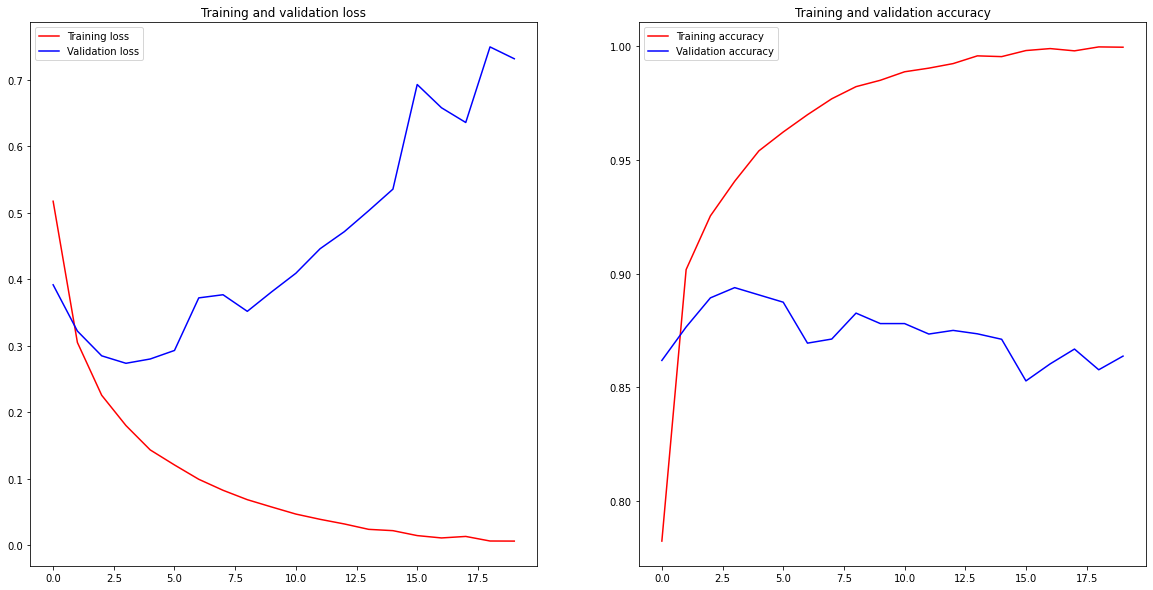

In [80]:
import matplotlib.pyplot as plt

history = history_original.history

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training accuracy')
axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].legend(loc=0)

In [81]:
# 작은 모델로 바꿔보자
model = keras.Sequential([
    # Dense(16, activation='relu') 이였던것을 아래와 같이 축소
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics="accuracy")
history_smaller_model = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 48ms/step - loss: 0.6095 - accuracy: 0.7679 - val_loss: 0.5283 - val_accuracy: 0.8388
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.4639 - accuracy: 0.8764 - val_loss: 0.4348 - val_accuracy: 0.8621
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3682 - accuracy: 0.8971 - val_loss: 0.3653 - val_accuracy: 0.8752
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.3016 - accuracy: 0.9111 - val_loss: 0.3221 - val_accuracy: 0.8839
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2534 - accuracy: 0.9229 - val_loss: 0.2966 - val_accuracy: 0.8879
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2185 - accuracy: 0.9321 - val_loss: 0.2848 - val_accuracy: 0.8882
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1924 - accuracy: 0.9391 - val_loss: 0.2748 - val_accuracy: 0.8911
Epoch 8/20
30

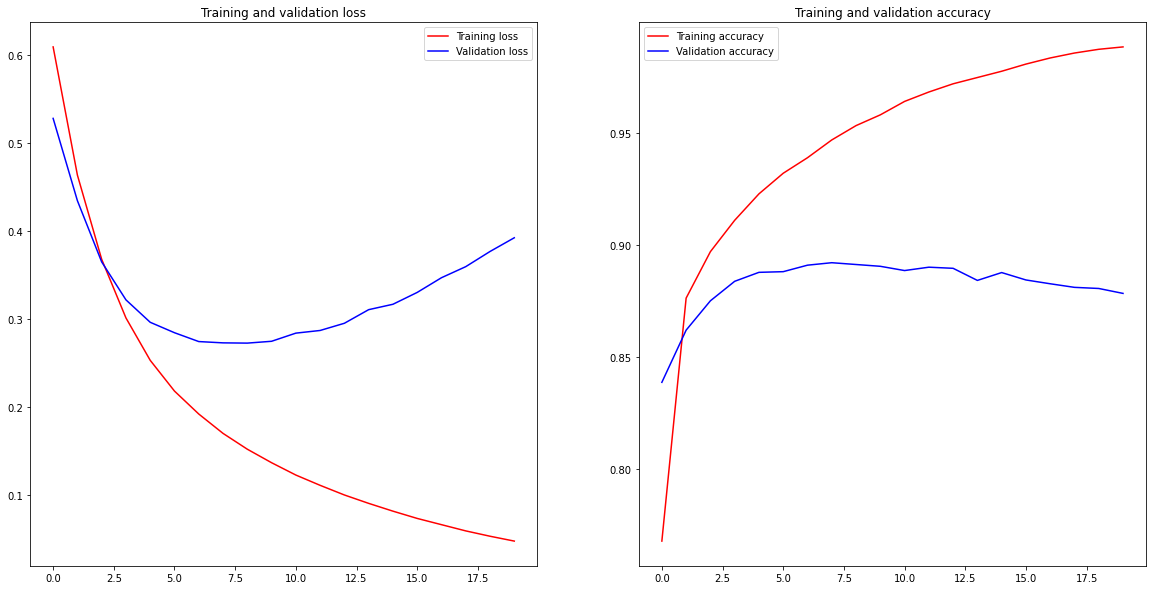

In [82]:
import matplotlib.pyplot as plt

history = history_smaller_model.history

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, acc, 'r', label='Training accuracy')
axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].legend(loc=0)

accuaracy 그래프를 확인해보면 작은 모델이 기본 모델보다 더 나중에 과대적합되기 시작한 것을 확인할 수 있다. 이때 성능 역시 더 천천히 감소되었다.

In [83]:
# 큰 용량의 모델
model = keras.Sequential([
    # Dense(16, activation='relu') 이였던것을 아래와 같이 축소
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics="accuracy")
history_larger_model = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 12s 377ms/step - loss: 0.5575 - accuracy: 0.7554 - val_loss: 0.3065 - val_accuracy: 0.8874
Epoch 2/20
30/30 [==============================] - 9s 315ms/step - loss: 0.2413 - accuracy: 0.9068 - val_loss: 0.3296 - val_accuracy: 0.8519
Epoch 3/20
30/30 [==============================] - 9s 312ms/step - loss: 0.1456 - accuracy: 0.9469 - val_loss: 0.3874 - val_accuracy: 0.8615
Epoch 4/20
30/30 [==============================] - 9s 297ms/step - loss: 0.0961 - accuracy: 0.9695 - val_loss: 0.3845 - val_accuracy: 0.8866
Epoch 5/20
30/30 [==============================] - 9s 298ms/step - loss: 0.0484 - accuracy: 0.9904 - val_loss: 0.7351 - val_accuracy: 0.8075
Epoch 6/20
30/30 [==============================] - 10s 321ms/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.5252 - val_accuracy: 0.8877
Epoch 7/20
30/30 [==============================] - 9s 313ms/step - loss: 5.3040e-04 - accuracy: 1.0000 - val_loss: 0.6269 - val_accuracy: 0.8863


용량이 큰 모델은 빠르게 과대적합이 시작되어 갈수록 더 심해지며 검증 손실도 매우 불안정 한 것을 확인할 수 있었다. 용량이 많은(큰) 모델일 수록 더 빠르게 훈련 데이터를 모델링 하며 훈련손실을 낮출 수 있지만, 과대적합에 매우 민감해지며 훈련과 vaildation 손실 사이에 큰 차이를 발생시킬 수 있다.

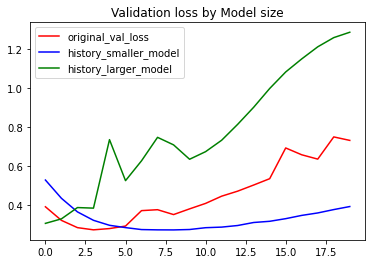

In [84]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

original_val_loss = history_original.history['val_loss']
smaller_val_loss = history_smaller_model.history['val_loss']
larger_val_loss = history_larger_model.history['val_loss']

plt.plot(range(len(original_val_loss)), original_val_loss, 'r', label='original_val_loss')
plt.plot(range(len(smaller_val_loss)), smaller_val_loss, 'b', label='history_smaller_model')
plt.plot(range(len(larger_val_loss)), larger_val_loss, 'g', label='history_larger_model')
plt.title('Validation loss by Model size')
plt.legend(loc=0)

original에 비해 smaller 모델이 과대적합을 더 잘 견디는 모습과. larger 모델이 빠르게 과대적합되는 모습을 한 눈에 확인할 수 있었다.

## 일반화 성능 향상하기 - 가중치 규제 추가
오캄의 면도날 이론(Occam's razor) 이론은 어떤 것에 대한 두 가지의 설명이 있다면 더 적은 가정이 필요한 간단한 설명이 옳을 것이라는 이론이다. 이 개념은 신경망으로 학습되는 모델에도 적용된다. 어떠한 train data와 네트워크 구조가 주어졌을 때 데이터를 설명할 수 있는 가중치 값의 집합(모델)은 여러개입니다. 간단한 모델이 복잡한 모델보다 덜 과대적합 될 가능성이 높다.
<br><br>
여기서 말하는 간단한 모델은 파라미터 값 분포의 엔트로피가 작은 혹은 파라미터의 수가 적은 모델을 뜻한다. 그러므로 과대적합을 완화하기 위한 일반적인 방법은 모델의 복잡도에 제한을 두어 가중치가 작은 값을 가지도록 강제하며, 가중치 값의 분포가 더 균일하게 된다. 이를 가중치 규제(weight regularization)라고 하며 모델의 손실 함수에 큰 가중치에 연관된 비용을 추가한다.

- L1 규제 : 가중치의 절댓값에 비례하는 비용이 추가
- L2 규제 : 가중치의 제곱에 비례하는 비용이 추가된다. 신경망에서는 가중치 감쇠(weight decay)라고도 부른다.

### regularizers

In [85]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    # 가중치 행렬의 모든 원소를 제곱하고 0.002를 곱해 모델의 전체 전실에 더해진다는 것을 의미
    # 이러한 페널티 항은 훈련할 때만 추가된다.
    # 페널티 = 손실함수에 추가로 더해지는 규제
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation='relu'),
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = 'accuracy')
history_L2_reg = model.fit(
    train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5808 - accuracy: 0.7941 - val_loss: 0.4525 - val_accuracy: 0.8705
Epoch 2/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3864 - accuracy: 0.8965 - val_loss: 0.3891 - val_accuracy: 0.8766
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.3223 - accuracy: 0.9173 - val_loss: 0.3608 - val_accuracy: 0.8876
Epoch 4/20
30/30 [==============================] - 2s 62ms/step - loss: 0.2937 - accuracy: 0.9251 - val_loss: 0.3626 - val_accuracy: 0.8847
Epoch 5/20
30/30 [==============================] - 2s 59ms/step - loss: 0.2767 - accuracy: 0.9328 - val_loss: 0.3602 - val_accuracy: 0.8872
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2619 - accuracy: 0.9373 - val_loss: 0.3611 - val_accuracy: 0.8874
Epoch 7/20
30/30 [==============================] - 1s 39ms/step - loss: 0.2540 - accuracy: 0.9405 - val_loss: 0.3607 - val_accuracy: 0.8853
Epoch 8/20
30

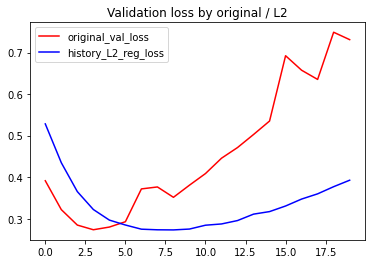

In [86]:
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

original_val_loss = history_original.history['val_loss']
history_L2_reg_loss = history_L2_reg.history['val_loss']

plt.plot(range(len(original_val_loss)), original_val_loss, 'r', label='original_val_loss')
plt.plot(range(len(history_L2_reg_loss)), smaller_val_loss, 'b', label='history_L2_reg_loss')
plt.title('Validation loss by original / L2')
plt.legend(loc=0)

위 그래프는 L2 규제 페널티의 효과를 보여주고 있다. 두 모델이 동일한 파라미터 개수를 가지고 있더라도 규제를 사용한 모델이 기본 모델보다는 과대적합에 대해 잘 견디고 있는 듯 보인다.
<br>
케라스에서 사용할 수 있는 가중치 규제는 L2 대신에 아래와 같은 규제를 사용할 수도 있다
```python
from tensorflow.keras import regularizers

regularizers.l1(0.001) # L1 규제
regularizers.l1_l2(l1=0.001, l2=0.001) # L1 규제와 L2 규제의 병행
```
일반적으로 가중치 규제는 작은 딥러닝 모델에서 사용된다. 대규모 딥러닝 모델은 파라미터가 너무 많기 때문에 가중치 값을 제약하는 것이 모델 용량과 일반화에 큰 영향을 미치지 않는 경향이 있기 때문이다.

In [87]:
# 하나만 더 해보기 : L1 규제
from tensorflow.keras import regularizers

model = keras.Sequential([
    # 가중치 행렬의 모든 원소를 제곱하고 0.002를 곱해 모델의 전체 전실에 더해진다는 것을 의미
    # 이러한 페널티 항은 훈련할 때만 추가된다.
    # 페널티 = 손실함수에 추가로 더해지는 규제
    Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = 'accuracy')
history_L1_reg = model.fit(
    train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 57ms/step - loss: 1.1009 - accuracy: 0.6876 - val_loss: 0.7679 - val_accuracy: 0.7227
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.7148 - accuracy: 0.8129 - val_loss: 0.6821 - val_accuracy: 0.8326
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.6462 - accuracy: 0.8399 - val_loss: 0.6478 - val_accuracy: 0.8315
Epoch 4/20
30/30 [==============================] - 1s 36ms/step - loss: 0.6034 - accuracy: 0.8517 - val_loss: 0.6401 - val_accuracy: 0.8207
Epoch 5/20
30/30 [==============================] - 1s 41ms/step - loss: 0.5753 - accuracy: 0.8558 - val_loss: 0.5827 - val_accuracy: 0.8543
Epoch 6/20
30/30 [==============================] - 1s 45ms/step - loss: 0.5557 - accuracy: 0.8603 - val_loss: 0.5626 - val_accuracy: 0.8628
Epoch 7/20
30/30 [==============================] - 1s 44ms/step - loss: 0.5399 - accuracy: 0.8659 - val_loss: 0.5575 - val_accuracy: 0.8604
Epoch 8/20
30

In [88]:
history_L1_reg_loss = history_L1_reg.history['val_loss']

음... L2 규제를 적용시켰을 때와 L1 규제를 적용시켰을 때의 loss 그래프가 동일하게 나온건지 겹쳐서 L2가 가려졌다

## ImageDataGenerator
이미지 데이터가 부족할 때 사용해 줄 수 있다. 그렇다고 무작정 이미지를 늘리기만 한다면 안그래도 용량을 많이 차지하는 이미지 데이터 들이기 때문에 RAM 이 터져버릴 수도 있다. ImageDataGenerator는 메모리 상에는 기본 이미지만 올려놓고 학습시 배치 단위로 입력이 들어갈 때, 조금씩 변경하며 데이털르 입력해주는 방식으로 큰 메모리 손실 없이 많은 데이터를 학습 하게 하는 생성기이다.

<br>
케라스에서 제공하는 이미지 제너레이터는 아래와 같은데

```
ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

```
보통 아래 정도만 알고 있으면 좋을 듯하다.
```
train_datagen = ImageDataGenerator(
    # 0과 1사이로 변경
    rescale = 1./255,
    # 좌우이동 30%
    width_shift_range=0.3,
    # 회전각도 90도 이내
    rotation_range = 90,
    # 상하이동 40$
    height_shift_range=0.4,
    # 상하/좌우 반전 True
    vertical_flip = True,
    horizontal_flip = True
)

....
model.fit(
  train_datagen.flow(train_images, train_label, batch_size= ),
  steps_per_epoch = ,
  epochs = ,
  validation_data = (val_images/255, val_labels),
  validation_steps =
)
```
의 모양으로 사용